# DATA 200 Final Project (Peng Gu, Xi Chen, Kewei Sui)

## Imports and Reading Data

In [61]:
# import all packages
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [62]:
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble

In [63]:
# Read in the 2 datasets we will be using

df_player = pd.read_csv('dataset/2012-18_playerBoxScore.csv')
df_all_nba_team = pd.read_csv('dataset/2012-18_all_nba_team.csv')

## Exploratory Data Analysis (EDA)

In [64]:
# Change data related columns to python datetime type
df_player['gmDate'] = pd.to_datetime(df_player["gmDate"])
df_player['playBDate'] = pd.to_datetime(df_player["playBDate"])

# Add a column 'age' to the dataframe
df_player['age'] = df_player['gmDate'] - df_player['playBDate']
df_player['age'] = df_player['age'].dt.days / 365.0

In [65]:
# Match each season to a year
start_dates = ['2012-10-30', '2013-10-29', '2014-10-28', '2015-10-27','2016-10-25','2017-10-17','2018-10-16']
for i in range(len(start_dates)):
    start_dates[i] = datetime.datetime.strptime(start_dates[i],'%Y-%m-%d')

def setSeasons(gm_date):
    for i in range(len(start_dates) - 1):
        if gm_date >= start_dates[i] and gm_date < start_dates[i + 1]:
            return start_dates[i].year

df_player["seasYear"] = df_player['gmDate'].apply(lambda x:setSeasons(x))

In [66]:
# Merge two datasets into one, add is_all_nba flag
df_all_nba_team['is_all_nba'] = 1
df_player = df_player.merge(right=df_all_nba_team, how='left', left_on=['playDispNm','seasYear'], right_on=['name','year'])
df_player = df_player.drop(columns=['name','year','position','team'])
df_player['sub_team'].fillna(0, inplace=True)
df_player['is_all_nba'].fillna(0,inplace=True)
# df_player.columns
# df_player.head()

In [67]:
# Adding two measuring metrics for player's performance
# 1. a column 'game score' (simplified PER)
df_player["gameScore"] = df_player["playPTS"] + 0.4 * df_player["playFGM"] - 0.7 * df_player["playFGA"] - 0.4 * (df_player["playFTA"] - df_player["playFTM"]) + 0.7 * df_player["playORB"] + 0.3 * df_player["playDRB"] + df_player["playSTL"] + 0.7 * df_player["playAST"] + 0.7 * df_player["playBLK"] - 0.4 * df_player["playPF"] - df_player["playTO"]

# 2. a column 'FIC40'
df_player['playFIC40'] = ((df_player['playPTS'] + df_player['playORB'] + 0.75 * df_player['playDRB'] + df_player['playAST'] + df_player['playSTL'] + df_player['playBLK']
- 0.75 * df_player['playFGA'] - 0.375 * df_player['playFTA'] - df_player['playTO'] - 0.5 * df_player['playPF']) * 40 * 5) / df_player['playMin']

# Simplify player's position to guard as G, foward as F, and center as C
df_player["playPos"] = df_player["playPos"].replace({'PG':'G', 'SG':'G', 'SF':'F', 'PF':'F'})


## Data Visualization

In [38]:
# EDA & Visualizations

fig = px.scatter(
    df_player, x='playHeight', y='playWeight',
    color='playPos', category_orders=dict(pos_simple=['G', 'C', 'F']),
    marginal_x="histogram", marginal_y="histogram")

fig.update_layout(
    title="NBA Player Height vs. Weight Distribution (2012-2018)",
    xaxis_title="Height (inches)",
    yaxis_title="Weight (Lbs)",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#090909"
    )
)
fig.show()

In [39]:
fig = px.scatter(
    df_player, x='age', y='gameScore'
    #, color='age', color_continuous_scale=px.colors.sequential.Teal,
)

fig.update_layout(
    title="NBA Player Age vs. Game Score (Simplified PER) (2012-2018)",
    xaxis_title="Age (yrs)",
    yaxis_title="Game Score ",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#090909"
    )
)

fig.show()

In [40]:
fig = px.scatter(
    df_player, x='playHeight', y='gameScore'
    #, color='age', color_continuous_scale=px.colors.sequential.Teal,
)

fig.update_layout(
    title="NBA Player Height vs. Game Score (Simplified PER) (2012-2018)",
    xaxis_title="Height (inches)",
    yaxis_title="Game Score ",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#090909"
    )
)

fig.show()

In [41]:
fig = px.scatter(
    df_player, x='playWeight', y='gameScore'
    #, color='age', color_continuous_scale=px.colors.sequential.Teal,
)

fig.update_layout(
    title="NBA Player Weight vs. Game Score (Simplified PER) (2012-2018)",
    xaxis_title="Weight (lbs)",
    yaxis_title="Game Score ",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#090909"
    )
)

fig.show()

In [42]:
fig = px.scatter(
    df_player, x='teamAbbr', y='gameScore'
    , color='age', color_continuous_scale=px.colors.sequential.Teal,
)

fig.update_layout(
    title="NBA Player teamAbbr vs. Game Score (Simplified PER) (2012-2018)",
    xaxis_title="Teams",
    yaxis_title="Game Score ",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#090909"
    )
)

fig.show()

In [43]:
corrmat = df_player.corr()
f, ax = plt.subplots(figsize=(20,18))
sns.heatmap(corrmat, vmax=.8, square=True)

ax.set_title('Correlation Heatmap between Features');

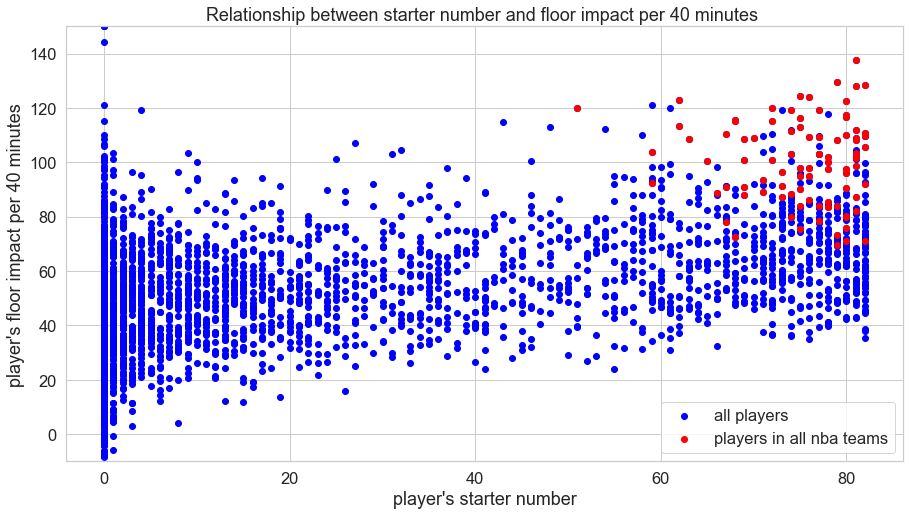

In [68]:
# # Merging tables to explore relationship between the number of times a player play as a starter vs. FIC score
player_starter_bench = pd.pivot_table(data=df_player, index=['playDispNm','seasYear'],columns='playStat',values='teamAbbr',aggfunc='count')
player_starter_bench = player_starter_bench.fillna(0).reset_index()

allnba_starter_bench = player_starter_bench.merge(right=df_all_nba_team, how='inner', left_on=['playDispNm', 'seasYear'], right_on=['name','year'])
allnba_starter_bench.drop(columns=['name', 'year'], inplace=True)
allnba_starter_bench.sort_values(by=['seasYear', 'sub_team'], inplace=True, ascending=True)


df_player_starter_vs_FIC40 = df_player[['playDispNm', 'playFIC40', 'seasYear']].groupby(["playDispNm", "seasYear"]).mean()
df_player_starter_vs_FIC40 = df_player_starter_vs_FIC40.merge(player_starter_bench, on=['playDispNm', 'seasYear'], how='inner')

plt.figure(figsize=(15,8))
plt.ylim(-10, 150)
plt.title("Relationship between starter number and floor impact per 40 minutes ")
plt.xlabel("player's starter number")
plt.ylabel("player's floor impact per 40 minutes")

df_allnba_starter_vs_FIC40 = df_player_starter_vs_FIC40.merge(allnba_starter_bench, on=["playDispNm", "seasYear", "Bench", "Starter"])

plt.scatter(df_player_starter_vs_FIC40['Starter'], df_player_starter_vs_FIC40["playFIC40"], color='blue', label="all players")
plt.scatter(df_allnba_starter_vs_FIC40['Starter'], df_allnba_starter_vs_FIC40['playFIC40'], color='red', label="players in all nba teams")
plt.legend();


## Data Processing for Model

### Data Cleaning and filtering

In [69]:
# We find out in the dataset "2012-18_playerBoxScore.csv", and there is no data for the pre or post season
# Thus, we will only evaluate players based on their performances in the regular season
df_player = df_player[df_player.seasTyp != 'Pre']
df_player = df_player[df_player.seasTyp != 'Post']

df_player = df_player.replace([np.inf, -np.inf], np.nan)
# df_player.columns

In [70]:
# Data cleaning
df_player['offLNm3'] = df_player['offLNm3'].fillna(df_player['offLNm2'])
df_player['offFNm3'] = df_player['offFNm3'].fillna(df_player['offFNm2'])
# df_player.loc[df_player['playDispNm'] == 'Goran Dragić']['playDispNm'] = 'Goran Dragic'
df_player['playDispNm'] = df_player['playDispNm'].replace({'Goran Dragić':'Goran Dragic'})
# df_player.isna().sum()
# Data cleaning
df_player = df_player.drop(columns=['teamDiv', 'teamDayOff', 'offLNm1', 'offFNm1', 'offLNm2', 'offFNm2', \
      'offLNm3', 'offFNm3', 'opptDiv', 'opptDayOff'])
df_player['age'] = df_player['age'] * 365.0

### One Hot Encoding

In [71]:
new_df_player = df_player
new_df_player['teamRslt'] = new_df_player['teamRslt'].replace(['Win', 'Loss'], [1, 0])
playStat_ohe = pd.get_dummies(new_df_player['playStat'])
new_df_player['sub_team'] = new_df_player['sub_team'].replace([1, 2, 3, 0], ['first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
sub_team_ohe = pd.get_dummies(new_df_player['sub_team'])
new_df_player['playPos'] = new_df_player['playPos'].replace(['F', 'C', 'G'], ['Forward', 'Center', 'Guard'])
new_df_player = pd.concat([new_df_player, playStat_ohe, sub_team_ohe], axis=1)

### Grouping Operations

In [72]:
# Seperate df_player into 6 small data frames
df_player_collection = {}
for i in range(2012, 2018):
    df_player_collection[i] = new_df_player[new_df_player["seasYear"] == i]

In [73]:
# Calculate player average performance in each year
def regularizeDataPerYear(df):
    df_mostPlayPos = df.groupby('playDispNm')['playPos'].apply(lambda x: x.mode().iat[0])
    df_sumStarter = df.groupby('playDispNm')['Starter'].agg('sum')
    df_sumBench = df.groupby('playDispNm')['Bench'].agg('sum')
    #df_mostTeamAbbr = df_player_2012.groupby('playDispNm')['teamAbbr'].agg(pd.Series.mode)
    #df_mostTeamConf = df_player_2012.groupby('playDispNm')['teamConf'].agg(pd.Series.mode)

    df = df.groupby('playDispNm').agg('mean')
    df = pd.concat([df, df_mostPlayPos], axis=1)
    df['Starter'] = df_sumStarter
    df['Bench'] = df_sumBench

    playPos_ohe = pd.get_dummies(df['playPos'])
    df = pd.concat([df, playPos_ohe], axis=1)

    df = df.reset_index()
    df = df.drop(columns=['playDispNm', 'playPos', 'seasYear', 'playFIC40'])

    return df

In [74]:
# Regularize data in each year
for i in range(2012, 2018):
    df_player_collection[i] = regularizeDataPerYear(df_player_collection[i])

## Models

### Random Forest Model

In [75]:
def RandomForestModel(df):
    # Train Test split (Unstratified)
    '''
    np.random.seed(47)
    X = df.drop(columns=['is_allnba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])

    # Choose different Y
    Y = pd.Series(df['is_allnba'])
    #Y = pd.Series(df_model['first_team'])
    #Y = pd.Series(df_model['second_team'])
    #Y = pd.Series(df_model['thrid_team'])
    #Y = pd.Series(df_model['isnt_allnba'])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    '''

    # Train test split (Stratified)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=47)

    # Stratify the data by category and store value into train and test sets
    for train_index, test_index in split.split(df, df['is_all_nba']):
        train_set = df.loc[train_index]
        test_set = df.loc[test_index]

    X_train = train_set.drop(columns=['is_all_nba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
    X_test = test_set.drop(columns=['is_all_nba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
    Y_train = pd.Series(train_set['is_all_nba'])
    Y_test = pd.Series(test_set['is_all_nba'])

    # Random forest model
    random_forest_model = ensemble.RandomForestClassifier(n_estimators=100)
    random_forest_model.fit(X_train, Y_train)
    Y_predict = random_forest_model.predict(X_test)
    Y_fitted = random_forest_model.predict(X_train)

    # Calculate precision, recall, false-alarm, F-Score and training & testing accuracy
    training_TP = 0
    training_FP = 0
    training_FN = 0
    training_TN = 0

    testing_TP = 0
    testing_FP = 0
    testing_FN = 0
    testing_TN = 0

    Y_train_array = Y_train.to_numpy()
    Y_test_array = Y_test.to_numpy()

    for i in range(len(X_train)):
        if Y_fitted[i] == 1 and Y_train_array[i] == 1:
            training_TP += 1
        elif Y_fitted[i] == 1 and Y_train_array[i] == 0:
            training_FP += 1
        elif Y_fitted[i] == 0 and Y_train_array[i] == 1:
            training_FN += 1
        elif Y_fitted[i] == 0 and Y_train_array[i] == 0:
            training_TN += 1

    for i in range(len(X_test)):
        if Y_predict[i] == 1 and Y_test_array[i] == 1:
            testing_TP += 1
        elif Y_predict[i] == 1 and Y_test_array[i] == 0:
            testing_FP += 1
        elif Y_predict[i] == 0 and Y_test_array[i] == 1:
            testing_FN += 1
        elif Y_predict[i] == 0 and Y_test_array[i] == 0:
            testing_TN += 1

    training_precision = 0
    training_recall = 0
    training_far = 0
    training_f_measure = 0

    if training_TP is not 0:
        training_precision = training_TP / (training_TP + training_FP)
        training_recall = training_TP / (training_TP + training_FN)
    if training_FP is not 0:
        training_far = training_FP / (training_FP + training_TN)
    if training_precision is not 0:
        training_f_measure = 2.0 * training_precision * training_recall / (training_precision + training_recall)

    testing_precision = 0
    testing_recall = 0
    testing_far = 0
    testing_f_measure = 0

    if testing_TP is not 0:
        testing_precision = testing_TP / (testing_TP + testing_FP)
        testing_recall = testing_TP / (testing_TP + testing_FN)
    if testing_FP is not 0:
        testing_far = testing_FP / (testing_FP + testing_TN)
    if testing_precision is not 0:
        testing_f_measure = 2.0 * testing_precision * testing_recall / (testing_precision + testing_recall)

    training_accuracy = sum(Y_train == Y_fitted) / len(Y_fitted)
    testing_accuracy = sum(Y_test == Y_predict) / len(Y_test)

    '''
    print("Training Accuracy:", training_accuracy)
    print("Testing Accuracy:", testing_accuracy)

    print("Training Precision:", training_precision)
    print("Training Recall:", training_recall)
    print("Training False-alarm:", training_far)
    print("Training F-Measure:", training_f_measure)

    print("Testing Precision:", testing_precision)
    print("Testing Recall:", testing_recall)
    print("Testing False-alarm:", testing_far)
    print("Testing F-Measure:", testing_f_measure)
    '''

    return [training_accuracy, training_precision, training_recall, training_far, training_f_measure, testing_accuracy, testing_precision, testing_recall, testing_far, testing_f_measure]

### Random Forest Model Evaluation

In [76]:
totalPerformance = [[] for _ in range(10)]

for i in range(2012, 2018):
    result = RandomForestModel(df_player_collection[i])
    for i in range(10):
        totalPerformance[i].append(result[i])

Text = ["Average Training Accuracy:", "Average Training Precision:", "Average Training Recall:", "Average Training False-alarm:", "Average Training F-Measure:", "Average Testing Accuracy:", "Average Testing Precision:", "Average Testing Recall:", "Average Testing False-alarm:", "Average Testing F-Measure:"]

for i in range(10):
    print(Text[i], np.mean(totalPerformance[i]), "Std:", np.std(totalPerformance[i]))

Average Training Accuracy: 1.0 Std: 0.0
Average Training Precision: 1.0 Std: 0.0
Average Training Recall: 1.0 Std: 0.0
Average Training False-alarm: 0.0 Std: 0.0
Average Training F-Measure: 1.0 Std: 0.0
Average Testing Accuracy: 0.9813235918106648 Std: 0.01249974213210002
Average Testing Precision: 0.6666666666666666 Std: 0.3435921354681384
Average Testing Recall: 0.611111111111111 Std: 0.35572912430182496
Average Testing False-alarm: 0.007055661416753963 Std: 0.0049901537204575935
Average Testing F-Measure: 0.6190476190476191 Std: 0.3188698865292039


## Logistic Regression Model with Cross Validation

In [77]:
def LogisticModel(df):
    # Train Test split (Unstratified)
    '''
    np.random.seed(47)
    X = df.drop(columns=['is_allnba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])

    # Choose different Y
    Y = pd.Series(df['is_allnba'])
    #Y = pd.Series(df_model['first_team'])
    #Y = pd.Series(df_model['second_team'])
    #Y = pd.Series(df_model['thrid_team'])
    #Y = pd.Series(df_model['isnt_allnba'])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    '''

    # Train test split (Stratified)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=47)

    # Stratify the data by category and store value into train and test sets
    for train_index, test_index in split.split(df, df['is_all_nba']):
        train_set = df.loc[train_index]
        test_set = df.loc[test_index]

    X_train = train_set.drop(columns=['is_all_nba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
    X_test = test_set.drop(columns=['is_all_nba', 'first_team', 'second_team', 'thrid_team', 'isnt_allnba'])
    Y_train = pd.Series(train_set['is_all_nba'])
    Y_test = pd.Series(test_set['is_all_nba'])

    # Logistic regression model
    logistic_model = lm.LogisticRegressionCV(fit_intercept=True, cv=10, penalty='l1', solver='liblinear', max_iter=10000)
    #logistic_model = lm.RidgeCV(fit_intercept=True, cv=10)
    logistic_model.fit(X_train, Y_train)
    Y_predict = logistic_model.predict(X_test)
    Y_fitted = logistic_model.predict(X_train)

    # Calculate precision, recall, false-alarm, F-Score and training & testing accuracy
    training_TP = 0
    training_FP = 0
    training_FN = 0
    training_TN = 0

    testing_TP = 0
    testing_FP = 0
    testing_FN = 0
    testing_TN = 0

    Y_train_array = Y_train.to_numpy()
    Y_test_array = Y_test.to_numpy()

    for i in range(len(X_train)):
        if Y_fitted[i] == 1 and Y_train_array[i] == 1:
            training_TP += 1
        elif Y_fitted[i] == 1 and Y_train_array[i] == 0:
            training_FP += 1
        elif Y_fitted[i] == 0 and Y_train_array[i] == 1:
            training_FN += 1
        elif Y_fitted[i] == 0 and Y_train_array[i] == 0:
            training_TN += 1

    for i in range(len(X_test)):
        if Y_predict[i] == 1 and Y_test_array[i] == 1:
            testing_TP += 1
        elif Y_predict[i] == 1 and Y_test_array[i] == 0:
            testing_FP += 1
        elif Y_predict[i] == 0 and Y_test_array[i] == 1:
            testing_FN += 1
        elif Y_predict[i] == 0 and Y_test_array[i] == 0:
            testing_TN += 1

    training_precision = 0
    training_recall = 0
    training_far = 0
    training_f_measure = 0

    if training_TP is not 0:
        training_precision = training_TP / (training_TP + training_FP)
        training_recall = training_TP / (training_TP + training_FN)
    if training_FP is not 0:
        training_far = training_FP / (training_FP + training_TN)
    if training_precision is not 0:
        training_f_measure = 2.0 * training_precision * training_recall / (training_precision + training_recall)

    testing_precision = 0
    testing_recall = 0
    testing_far = 0
    testing_f_measure = 0

    if testing_TP is not 0:
        testing_precision = testing_TP / (testing_TP + testing_FP)
        testing_recall = testing_TP / (testing_TP + testing_FN)
    if testing_FP is not 0:
        testing_far = testing_FP / (testing_FP + testing_TN)
    if testing_precision is not 0:
        testing_f_measure = 2.0 * testing_precision * testing_recall / (testing_precision + testing_recall)

    training_accuracy = sum(Y_train == Y_fitted) / len(Y_fitted)
    testing_accuracy = sum(Y_test == Y_predict) / len(Y_test)

    '''
    print("Training Accuracy:", training_accuracy)
    print("Testing Accuracy:", testing_accuracy)

    print("Training Precision:", training_precision)
    print("Training Recall:", training_recall)
    print("Training False-alarm:", training_far)
    print("Training F-Measure:", training_f_measure)

    print("Testing Precision:", testing_precision)
    print("Testing Recall:", testing_recall)
    print("Testing False-alarm:", testing_far)
    print("Testing F-Measure:", testing_f_measure)
    '''

    return [training_accuracy, training_precision, training_recall, training_far, training_f_measure, testing_accuracy, testing_precision, testing_recall, testing_far, testing_f_measure]

### Logistic Regression Model Evaluation

In [78]:
totalPerformance = [[] for _ in range(10)]

for i in range(2012, 2018):
    result = LogisticModel(df_player_collection[i])
    for i in range(10):
        totalPerformance[i].append(result[i])

Text = ["Average Training Accuracy:", "Average Training Precision:", "Average Training Recall:", "Average Training False-alarm:", "Average Training F-Measure:", "Average Testing Accuracy:", "Average Testing Precision:", "Average Testing Recall:", "Average Testing False-alarm:", "Average Testing F-Measure:"]

for i in range(10):
    print(Text[i], np.mean(totalPerformance[i]), "Std:", np.std(totalPerformance[i]))

Average Training Accuracy: 0.9991228070175439 Std: 0.0019614631381577163
Average Training Precision: 0.986111111111111 Std: 0.031056499687497092
Average Training Recall: 0.986111111111111 Std: 0.031056499687497092
Average Training False-alarm: 0.0004528985507246377 Std: 0.0010127119463314265
Average Training F-Measure: 0.986111111111111 Std: 0.031056499687497092
Average Testing Accuracy: 0.9796050134858639 Std: 0.008450837693618445
Average Testing Precision: 0.6805555555555555 Std: 0.1695354946629681
Average Testing Recall: 0.7222222222222222 Std: 0.12422599874998833
Average Testing False-alarm: 0.01239632400475698 Std: 0.007209833572008735
Average Testing F-Measure: 0.6888888888888888 Std: 0.1074217416869119
